In [1]:
import sys
print sys.executable

paths = ['', '/Users/dyawitz/anaconda/bin', '/Users/dyawitz/anaconda/lib/python27.zip', '/Users/dyawitz/anaconda/lib/python2.7/plat-darwin', '/Users/dyawitz/anaconda/lib/python2.7/plat-mac', '/Users/dyawitz/anaconda/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/dyawitz/anaconda/lib/python2.7/lib-tk', '/Users/dyawitz/anaconda/lib/python2.7/lib-old', '/Users/dyawitz/anaconda/lib/python2.7/lib-dynload', '/Users/dyawitz/anaconda/lib/python2.7/site-packages/Sphinx-1.3.1-py2.7.egg', '/Users/dyawitz/anaconda/lib/python2.7/site-packages/setuptools-18.5-py2.7.egg', '/Users/dyawitz/anaconda/lib/python2.7/site-packages', '/Users/dyawitz/anaconda/lib/python2.7/site-packages/aeosa', '/Users/dyawitz/anaconda/lib/python2.7/site-packages/IPython/extensions', '/Users/dyawitz/.ipython']

for i in paths:
   sys.path.append(i)

/Users/dyawitz/anaconda/envs/py27/bin/python


In [408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Import the 2012 subset of data

In [249]:
loads = pd.read_csv('load2012.csv')
weather = pd.read_csv('weather2012.csv')

# 1. Format datetime columns

In [250]:
weather['date'] = weather.dateutc.apply(lambda x: pd.to_datetime(x).date())
weather['timeest'] = weather.timeest.apply(lambda x: pd.to_datetime(x).time())
foo = weather[['date', 'timeest']].astype(str)
weather['timestamp'] = pd.to_datetime(foo['date'] + ' ' + foo['timeest'])
loads['timestamp'] = loads.timestamp.apply(lambda x: pd.to_datetime(x))

# 2. Add weather data to loads data
Weather data is on hourly intervals, loads data is every five minutes. This is a function to merge based on the nearest datetime, using K-nearest neighbors

In [255]:
from sklearn.neighbors import NearestNeighbors

def find_nearest(group, match, groupname):
    nbrs = NearestNeighbors(1).fit(match['timestamp'].values[:, None])
    dist, ind = nbrs.kneighbors(group['timestamp'].values[:, None])

    group['nearesttime'] = match['timestamp'].values[ind.ravel()]
    return group

In [256]:
loads = find_nearest(loads,weather,'timestamp')

In [258]:
full = loads.merge(weather, left_on='nearesttime', right_on='timestamp')

#Remove and rename redundant columns 
full = full[['timestamp_x', 'load', 'nearesttime', 'temperaturef', \
            'dewpointf', 'humidity', 'sealevelpressurein', 'winddirection', 'windspeedmph', \
            'precipitationin']].rename(columns={'timestamp_x': 'timestamp', 'nearesttime':'weathertime'})

### *Checkpoint: export data to csv*

In [261]:
full.to_csv('full2012.csv', index=False)

# 3. Create features

Create new features based on the timeseries. These first features come from [Barta et al. 2015](http://arxiv.org/pdf/1506.06972.pdf), who applied probabalistic modeling techniques (such as Gradient-Boosting Regression) to forecast electricity prices:

    `dow`: day of the week (integer 0-6)
    `doy`: day of the year (integer 0-365)
    `day`: day of the month (integer 1-31)
    `woy`: week of the year (integer 1-52)
    `month`: month of the year (integer 1-12)
    `hour`: hour of the day (integer 0-23)
    `minute`: minute of the day (integer 0-1339)
    
    `t_m24`: load value from 24 hours earlier
    `t_m48`: load value from 48 hours earlier
    `tdif`: difference between load and t_m24


In [362]:
#datetime value of one day
pday = pd.Timedelta('1 day')

def get_prev_days(x, n_days):
    '''Take a datetime (x) in the 'full' dataframe, and outputs the load value n_days before that datetime'''
    try:
        lo = full[full.timestamp == x - n_days*pday].load.values[0]
    except:
        lo = full[full.timestamp == x].load.values[0]
    return lo 

In [361]:
full['dow'] = full.timestamp.apply(lambda x: x.dayofweek)
full['doy'] = full.timestamp.apply(lambda x: x.dayofyear)
full['day'] = full.timestamp.apply(lambda x: x.day)
full['month'] = full.timestamp.apply(lambda x: x.month)
full['hour'] = full.timestamp.apply(lambda x: x.hour)
full['minute'] = full.timestamp.apply(lambda x: x.hour*60 + x.minute)

full['t_m24'] = full.timestamp.apply(get_prev_days, args=(1,))
full['t_m48'] = full.timestamp.apply(get_prev_days, args=(2,))
full['tdif'] = full['load'] - full['t_m24']

In [364]:
full.to_csv('full2012_features.csv', index=False)

# 4. Gradient Boosting Regression

In [366]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split

In [367]:
full.columns

Index([u'timestamp', u'load', u'weathertime', u'temperaturef', u'dewpointf',
       u'humidity', u'sealevelpressurein', u'winddirection', u'windspeedmph',
       u'precipitationin', u'dow', u'doy', u'day', u'month', u'hour',
       u'minute', u't_m24', u't_m48', u'tdif'],
      dtype='object')

In [463]:
X = full[[\
          'temperaturef',\
          'dewpointf', \
          'humidity', \
          'sealevelpressurein', \
         'windspeedmph', \
          'precipitationin',\
          'dow',\
          'doy', \
          'month',\
          'hour',\
         'minute',\
          't_m24', \
          't_m48', \
          'tdif'\
         ]]
y = full['load']

In [464]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [457]:
gbr = GradientBoostingRegressor(loss='ls', verbose=1, warm_start=True)

In [458]:
gbr_fitted = gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1       54422.8242            9.84s
         2       46096.6971           11.07s
         3       39293.9887            9.98s
         4       33773.5271            8.73s
         5       29246.6397            8.50s
         6       25568.6157            8.23s
         7       22550.6621            7.98s
         8       20025.1744            7.74s
         9       17956.5337            7.52s
        10       16236.3410            7.46s
        20        9033.7561            5.55s
        30        7353.5608            4.25s
        40        6528.5173            3.39s
        50        5909.5739            2.73s
        60        5598.7196            2.08s
        70        5323.0064            1.52s
        80        5056.9857            1.08s
        90        4865.8749            0.53s
       100        4670.0520            0.00s


In [459]:
gbr.score(X_test, y_test)

0.92513322840797652

In [460]:
gbr.score(X_train, y_train)

0.92779521041729107

# 5. Ordinary Least Squares Regression

In [465]:
import statsmodels.api as sm

model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   load   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.856e+06
Date:                Wed, 16 Mar 2016   Prob (F-statistic):               0.00
Time:                        16:19:54   Log-Likelihood:            -6.3477e+05
No. Observations:              107000   AIC:                         1.270e+06
Df Residuals:                  106987   BIC:                         1.270e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
temperaturef          -1.3140      0.172     -7.626      0.000        -1.652    -0.976
dewpointf              1.9076      0.183     10.447      0.000         1.550     2.265
humidity              -1.0322      0.080    -12.865      0.000        -1.189    -0.875
sealevelpressurein     8.2132      0.246     33.328      0.000         7.730     8.696
windspeedmph           0.4577      0.054      8.522      0.000         0.352     0.563
precipitationin      -51.7532     11.751     -4.404      0.000       -74.785   -28.721
dow                  -16.3734      0.145   -113.264      0.000       -16.657   -16.090
doy                    0.0893      0.032      2.824      0.005         0.027     0.151
month                 -2.4457      0.970     -2.522      0.012        -4.346    -0.545
hour                   1.7808      0.970      1.835      0.066        -0.121     3.683
minute                -0.0007      0.016     -0.042      0.967        -0.032     0.031
t_m24                  0.8563      0.003    290.160      0.000         0.851     0.862
t_m48                  0.0259      0.003      8.694      0.000         0.020     0.032
==============================================================================
Omnibus:                    11294.270   Durbin-Watson:                   0.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40839.219
Skew:                           0.509   Prob(JB):                         0.00
Kurtosis:                       5.850   Cond. No.                     8.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

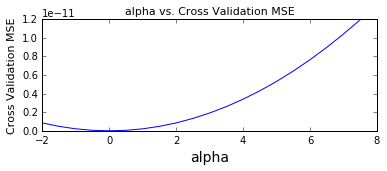

In [416]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

avg_MSE = []
alphas = np.linspace(-2, 8, 20, endpoint=False)
alphas
for alpha in alphas:
    MSE = []
    for i in range(20):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
#     model = sm.OLS(X_train, y_train)
        model = Ridge(alpha=alpha)
        model.fit(X_test, y_test)
        test_error = mean_squared_error(y_test, model.predict(X_test))
        MSE.append(test_error)
    avg_MSE.append(np.mean(MSE))

plt.figure(figsize=(6,2))
plt.xlabel('alpha', fontsize=14)
plt.ylabel('Cross Validation MSE', fontsize=11)
plt.title('alpha vs. Cross Validation MSE', fontsize=11)
plt.plot(alphas, avg_MSE)